<a href="https://colab.research.google.com/github/m3-learning/FOLO_RHEED/blob/main/GaussianEverywhereFOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2

def generate_gaussian_blob(image_size, mean, cov, angle):
    x, y = np.meshgrid(np.linspace(0, image_size[0] - 1, image_size[0]),
                       np.linspace(0, image_size[1] - 1, image_size[1]))
    x -= mean[0]
    y -= mean[1]

    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)

    x_rot = cos_angle * x + sin_angle * y
    y_rot = -sin_angle * x + cos_angle * y

    exponent = (x_rot ** 2) / (2 * cov[0] ** 2) + (y_rot ** 2) / (2 * cov[1] ** 2)
    blob = np.exp(-exponent)

    return blob

def create_training_data(num_samples, image_size=(48, 128), grid_size=(4, 8), num_blobs=5, noise_std=0.1):
    X = np.zeros((num_samples, image_size[0], image_size[1], 1), dtype=np.float32)
    y = np.zeros((num_samples, grid_size[0], grid_size[1], 5), dtype=np.float32)

    grid_height, grid_width = image_size[0] // grid_size[0], image_size[1] // grid_size[1]

    for i in range(num_samples):
        image = np.zeros((image_size[0], image_size[1]), dtype=np.float32)
        blob_params = []

        # Generate y-values within 20% of each other
        base_y = np.random.uniform(0.4 * image_size[0], 0.6 * image_size[0])
        y_values = np.random.uniform(base_y * 0.8, base_y * 1.2, num_blobs)

        # Generate evenly spaced x-values with slight variation
        x_values = np.linspace(0, image_size[1], num_blobs + 2)[1:-1]
        x_values = x_values + np.random.uniform(-4, 4, num_blobs)

        for j in range(num_blobs):
            mean_x = x_values[j]
            mean_y = y_values[j]
            cov_x = np.random.uniform(2, 6)
            cov_y = np.random.uniform(1, 5)
            theta = np.random.uniform(-10, 10) * np.pi / 180  # Cap rotation at 10 degrees

            blob = generate_gaussian_blob((image_size[1], image_size[0]), (mean_x, mean_y), (cov_x, cov_y), theta)
            image += blob

            grid_x = int(mean_x // grid_width)
            grid_y = int(mean_y // grid_height)

            if grid_x < grid_size[1] and grid_y < grid_size[0]:
                y[i, grid_y, grid_x, :] = [mean_x / image_size[1], mean_y / image_size[0], cov_x, cov_y, theta]

        # Add Gaussian noise to the image
        noise = np.random.normal(0, noise_std, image_size)
        image += noise

        # Normalize image to have pixel values between 0 and 1
        X[i, :, :, 0] = np.clip(image, 0, 1)

    return X, y

# Generate the training data with noise
num_samples = 10
X_sample, y_sample = create_training_data(num_samples)

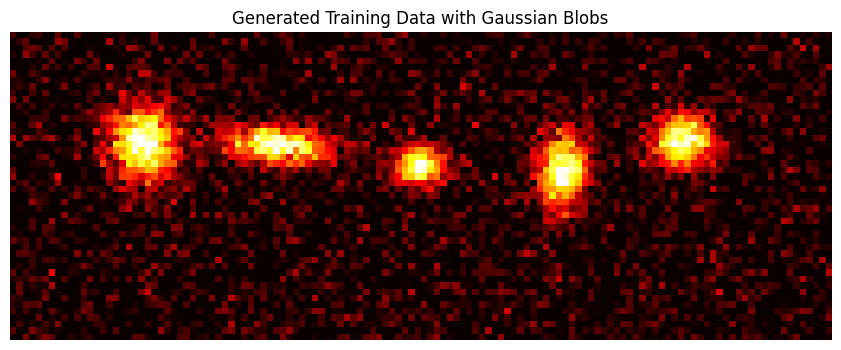

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def visualize_generated_data(X, y, image_index=0):
    fig, ax = plt.subplots(figsize=(12, 4))

    # Display the image with a black background
    ax.imshow(X[image_index, :, :, 0], cmap='hot', vmin=0, vmax=1)
    ax.set_facecolor('black')
    ax.set_title('Generated Training Data with Gaussian Blobs')

    # Create an overlay image with a black background
    overlay = np.zeros_like(X[image_index, :, :, 0])

    # Overlay the Gaussian blobs
    for grid_y in range(y.shape[1]):
        for grid_x in range(y.shape[2]):
            params = y[image_index, grid_y, grid_x]
            mean_x, mean_y = params[0] * X.shape[2], params[1] * X.shape[1]
            cov_x, cov_y, theta = params[2], params[3], params[4]

            if cov_x > 0 and cov_y > 0:
                center = (int(mean_x), int(mean_y))
                axes = (int(cov_x * 2), int(cov_y * 2))
                angle = np.degrees(theta)
                ellipse = cv2.ellipse(overlay, center, axes, angle, 0, 360, (255, 255, 255), 1)


    # Remove axis
    ax.axis('off')

    plt.show()

# Assuming X_sample and y_sample are defined
visualize_generated_data(X_sample, y_sample, image_index=0)

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Flatten, Dense, Reshape, MaxPool2D

def create_yolo_style_model(input_shape=(48, 128, 1), grid_size=(4, 8), params_per_blob=5):
    inputs = Input(shape=input_shape)

    x = Conv2D(8, (3, 3), padding='same')(inputs)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(16, (3, 3), padding='same')(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(16, (3, 3), padding='same')(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Flatten()(x)

    grid_cells = grid_size[0] * grid_size[1]
    output_units = grid_cells * params_per_blob
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Dense(output_units)(x)
    outputs = Reshape((grid_size[0], grid_size[1], params_per_blob))(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

import tensorflow as tf

def custom_loss(y_true, y_pred):
    # Split the true and predicted values into their respective components
    mean_x_true, mean_y_true, cov_x_true, cov_y_true, theta_true = tf.split(y_true, 5, axis=-1)
    mean_x_pred, mean_y_pred, cov_x_pred, cov_y_pred, theta_pred = tf.split(y_pred, 5, axis=-1)

    # Define the ranges for normalization (replace these with actual ranges if known)
    mean_x_range = 127.0  # Replace with the actual range of mean_x
    mean_y_range = 47.0  # Replace with the actual range of mean_y
    cov_x_range = 5.0   # Replace with the actual range of cov_x
    cov_y_range = 6.0  # Replace with the actual range of cov_y
    theta_range = 0.175   # Replace with the actual range of theta

    # Calculate the individual losses
    loss_mean_x = tf.reduce_mean(tf.square((mean_x_true - mean_x_pred) / mean_x_range))
    loss_mean_y = tf.reduce_mean(tf.square((mean_y_true - mean_y_pred) / mean_y_range))
    loss_cov_x = tf.reduce_mean(tf.square((cov_x_true - cov_x_pred) / cov_x_range))
    loss_cov_y = tf.reduce_mean(tf.square((cov_y_true - cov_y_pred) / cov_y_range))
    loss_theta = tf.reduce_mean(tf.square((theta_true - theta_pred) / theta_range))

    # Sum up the normalized losses to get the total loss
    total_loss = loss_mean_x + loss_mean_y + loss_cov_x + loss_cov_y + loss_theta

    return total_loss

# Create the model
model = create_yolo_style_model()
model.compile(optimizer='adam', loss=custom_loss)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 128, 1)]      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 48, 128, 8)        80        
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 24, 64, 8)         0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Bat  (None, 24, 64, 8)         32        
 chNormalization)                                                
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 24, 64, 8)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 64, 16)        1168

In [4]:
from sklearn.model_selection import train_test_split

# Generate the training data
num_samples = 10000
X, y = create_training_data(num_samples)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (8000, 48, 128, 1)
y_train shape: (8000, 4, 8, 5)
X_val shape: (2000, 48, 128, 1)
y_val shape: (2000, 4, 8, 5)


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

model = create_yolo_style_model()
model.compile(optimizer='adam', loss=physics_informed_loss)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/100
250/250 [==============================] - 8s 9ms/step - loss: 1.1326 - val_loss: 3.4034 - lr: 0.0010
Epoch 2/100
 23/250 [=>............................] - ETA: 1s - loss: 0.4642

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 1s 5ms/step - loss: 0.3832 - val_loss: 0.5522 - lr: 0.0010
Epoch 3/100
250/250 [==============================] - 1s 5ms/step - loss: 0.2569 - val_loss: 0.2907 - lr: 0.0010
Epoch 4/100
250/250 [==============================] - 1s 5ms/step - loss: 0.2145 - val_loss: 0.2905 - lr: 0.0010
Epoch 5/100
250/250 [==============================] - 1s 5ms/step - loss: 0.1931 - val_loss: 0.1955 - lr: 0.0010
Epoch 6/100
250/250 [==============================] - 1s 5ms/step - loss: 0.1796 - val_loss: 0.1786 - lr: 0.0010
Epoch 7/100
250/250 [==============================] - 1s 6ms/step - loss: 0.1710 - val_loss: 0.2116 - lr: 0.0010
Epoch 8/100
250/250 [==============================] - 1s 5ms/step - loss: 0.1593 - val_loss: 0.1983 - lr: 0.0010
Epoch 9/100
250/250 [==============================] - 1s 5ms/step - loss: 0.1593 - val_loss: 0.2570 - lr: 0.0010
Epoch 10/100
250/250 [==============================] - 1s 5ms/step - loss: 0.1550 - val_loss: 0.172

63/63 [==============================] - 0s 2ms/step - loss: 0.1099
Validation Loss: 0.10992862284183502


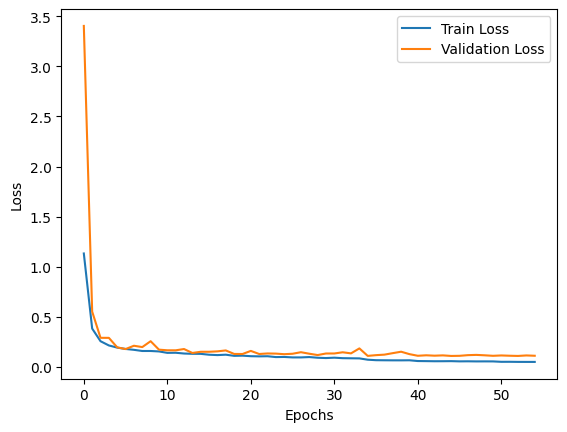

In [8]:
import matplotlib.pyplot as plt

# Load the best model
model.load_weights('best_model.h5')

# Evaluate on the validation set
val_loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gaussians_from_predictions(predictions, image_shape=(48, 128), threshold=0.1):
    # Create an empty image
    image = np.zeros(image_shape)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Iterate over the predictions
    for batch in range(predictions.shape[0]):  # Handle the batch dimension
        for grid_x in range(predictions.shape[1]):
            for grid_y in range(predictions.shape[2]):
                meanx, meany, covx, covy, theta = predictions[batch, grid_x, grid_y]
                meanx, meany = meanx * image_shape[1], meany * image_shape[0]

                # Only plot if covx and covy are noticeably above 0
                if covx > threshold and covy > threshold:
                    # Generate Gaussian blob for this prediction
                    blob = generate_blob(meanx, meany, covx, covy, theta, image_shape)

                    # Add the blob to the image
                    image += blob

    # Display the image
    ax.imshow(image, cmap='viridis', interpolation='none')
    ax.set_title('Generated Gaussians from Predictions')
    ax.axis('off')

    plt.show()

def generate_blob(meanx, meany, covx, covy, theta, shape):
    height, width = shape
    y, x = np.indices((height, width))

    # Ensure x and y are floats
    x = x.astype(float)
    y = y.astype(float)

    # Center the coordinates
    x -= meanx
    y -= meany

    # Rotate the coordinates
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)

    # Create the Gaussian blob
    blob = np.exp(-((x_rot**2) / (2 * covx**2) + (y_rot**2) / (2 * covy**2)))

    # Normalize the blob
    blob /= np.max(blob)

    return blob

1/1 [==============================] - 0s 17ms/step
(1, 4, 8, 5)


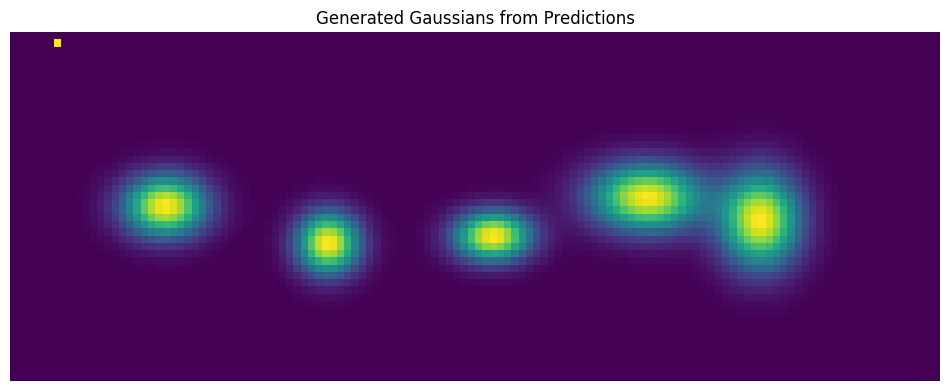

In [62]:
X_test, y_test = create_training_data(1)
y_pred = model.predict(X_test)

print(y_pred.shape)

# Visualize the first 5 examples
plot_gaussians_from_predictions(y_pred, image_shape=(48, 128), threshold=0.1)

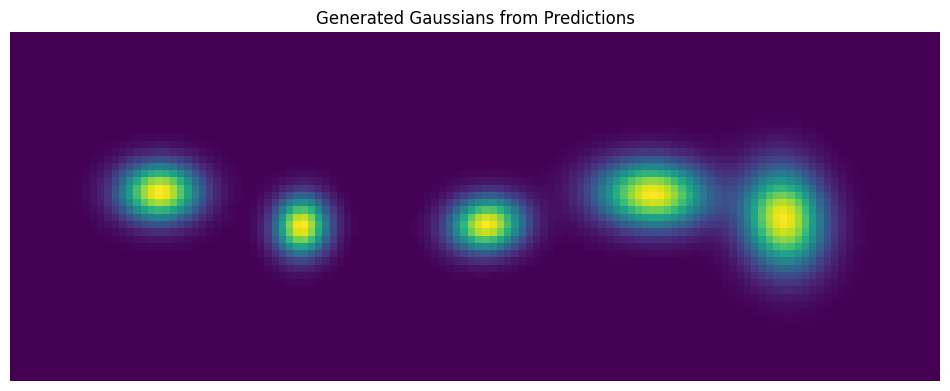

In [63]:
plot_gaussians_from_predictions(y_test, image_shape=(48, 128), threshold=0.1)